In [1]:
# SEQ Feature Visualization for m6A RNA Modification Prediction

"""
This notebook provides comprehensive visualizations to explore sequence features
and determine which features to extract for m6A modification prediction.

Based on research best practices for:
- Sequence logo generation (Logomaker, ggseqlogo)
- K-mer frequency analysis
- Position weight matrices
- Motif visualization
- Feature importance analysis

References:
- Logomaker: Tareen & Kinney (2019) Bioinformatics
- ggseqlogo: Wagih (2017) Bioinformatics
- m6Anet: Hendra et al. (2022) Nature Methods
"""


'\nThis notebook provides comprehensive visualizations to explore sequence features\nand determine which features to extract for m6A modification prediction.\n\nBased on research best practices for:\n- Sequence logo generation (Logomaker, ggseqlogo)\n- K-mer frequency analysis\n- Position weight matrices\n- Motif visualization\n- Feature importance analysis\n\nReferences:\n- Logomaker: Tareen & Kinney (2019) Bioinformatics\n- ggseqlogo: Wagih (2017) Bioinformatics\n- m6Anet: Hendra et al. (2022) Nature Methods\n'

In [2]:
# installation and imports

!pip install logomaker
!pip install biopython
!pip install seaborn
!pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import itertools
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# For sequence logos
try:
    import logomaker
    LOGOMAKER_AVAILABLE = True
except ImportError:
    print("Logomaker not available. Install with: pip install logomaker")
    LOGOMAKER_AVAILABLE = False

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

# Set figure size defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.0 MB/s eta 0:00:00


### Helper functions

In [3]:

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def extract_kmers(sequence: str, k: int) -> List[str]:
    """
    Extract all k-mers from a sequence.

    Parameters:
    -----------
    sequence : str
        Nucleotide sequence
    k : int
        K-mer length

    Returns:
    --------
    list of str
        List of k-mers
    """
    return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

def check_drach_motif(sequence: str) -> Dict[str, bool]:
    """
    Check for DRACH motifs in sequence.
    DRACH: D=A/G/T, R=A/G, A=A, C=C, H=A/C/T

    Returns dictionary with motif names and presence
    """
    D = ['A', 'G', 'T']
    R = ['A', 'G']
    H = ['A', 'C', 'T']

    motifs_found = {}
    for d in D:
        for r in R:
            for h in H:
                motif = f"{d}{r}AC{h}"
                motifs_found[motif] = motif in sequence

    return motifs_found

def get_nucleotide_composition(sequences: List[str]) -> pd.DataFrame:
    """
    Calculate nucleotide composition for a list of sequences.

    Returns DataFrame with composition statistics
    """
    compositions = []

    for seq in sequences:
        seq_len = len(seq)
        comp = {
            'A_freq': seq.count('A') / seq_len,
            'T_freq': seq.count('T') / seq_len,
            'G_freq': seq.count('G') / seq_len,
            'C_freq': seq.count('C') / seq_len,
            'GC_content': (seq.count('G') + seq.count('C')) / seq_len,
            'AT_content': (seq.count('A') + seq.count('T')) / seq_len,
            'purine': (seq.count('A') + seq.count('G')) / seq_len,
            'pyrimidine': (seq.count('C') + seq.count('T')) / seq_len,
        }
        compositions.append(comp)

    return pd.DataFrame(compositions)

def get_positional_matrix(sequences: List[str], max_len: int = 7) -> pd.DataFrame:
    """
    Create position-specific nucleotide frequency matrix.

    Parameters:
    -----------
    sequences : list of str
        List of sequences
    max_len : int
        Maximum sequence length (default 7 for m6A)

    Returns:
    --------
    pd.DataFrame
        Position weight matrix
    """
    # Initialize matrix
    nucleotides = ['A', 'T', 'G', 'C']
    pos_matrix = {nuc: [0] * max_len for nuc in nucleotides}

    # Count nucleotides at each position
    for seq in sequences:
        seq_padded = (seq + 'N' * max_len)[:max_len]
        for i, nuc in enumerate(seq_padded):
            if nuc in pos_matrix:
                pos_matrix[nuc][i] += 1

    # Normalize to frequencies
    n_seqs = len(sequences)
    for nuc in pos_matrix:
        pos_matrix[nuc] = [count / n_seqs for count in pos_matrix[nuc]]

    return pd.DataFrame(pos_matrix, index=range(max_len))

def create_sequence_logo_data(sequences: List[str], max_len: int = 7) -> pd.DataFrame:
    """
    Create data for sequence logo visualization.

    Returns DataFrame suitable for logomaker
    """
    pos_matrix = get_positional_matrix(sequences, max_len)

    # Transpose for logomaker format (positions as rows, nucleotides as columns)
    logo_data = pos_matrix.T
    logo_data.columns = range(max_len)

    return logo_data.T


In [14]:
df = pd.read_csv('output_w_label.csv')
df = df.drop(columns='Unnamed: 0')

In [15]:
# Get sequences by label
sequences_modified = df[df['label'] == 1]['SEQ'].tolist()
sequences_unmodified = df[df['label'] == 0]['SEQ'].tolist()

### 1.Nucleotide Composition Comparison

In [5]:
def viz_nucleotide_composition(df: pd.DataFrame,
                               sequences_modified: List[str],
                               sequences_unmodified: List[str],
                               save_path: str = None):
    """
    Visualize nucleotide composition differences between modified and unmodified sites.

    Best Practice: Bar plots for categorical comparisons (Wagih 2017)
    """
    # Calculate composition for both groups
    comp_modified = get_nucleotide_composition(sequences_modified)
    comp_unmodified = get_nucleotide_composition(sequences_unmodified)

    # Prepare data for plotting
    features = ['A_freq', 'T_freq', 'G_freq', 'C_freq', 'GC_content']
    feature_labels = ['A', 'T', 'G', 'C', 'GC Content']

    modified_means = comp_modified[features].mean()
    unmodified_means = comp_unmodified[features].mean()

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(feature_labels))
    width = 0.35

    bars1 = ax.bar(x - width/2, modified_means, width, label='Modified (m6A+)',
                   color='#3498db', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, unmodified_means, width, label='Unmodified (m6A-)',
                   color='#e74c3c', alpha=0.8, edgecolor='black')

    ax.set_xlabel('Nucleotide', fontsize=14, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=14, fontweight='bold')
    ax.set_title('Nucleotide Composition: Modified vs Unmodified Sequences',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(feature_labels)
    ax.legend(fontsize=12, frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)

    autolabel(bars1)
    autolabel(bars2)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    # Statistical summary
    print("\\n" + "="*60)
    print("NUCLEOTIDE COMPOSITION ANALYSIS")
    print("="*60)
    print("\\nModified Sequences:")
    print(modified_means)
    print("\\nUnmodified Sequences:")
    print(unmodified_means)
    print("\\nDifferences (Modified - Unmodified):")
    print(modified_means - unmodified_means)


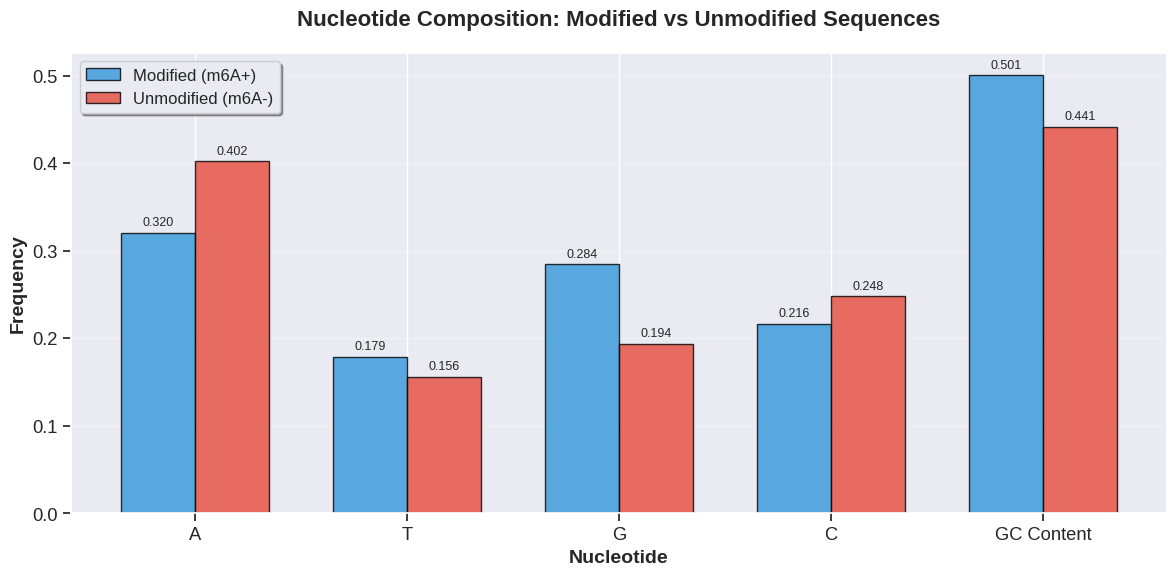

\n============================================================
NUCLEOTIDE COMPOSITION ANALYSIS
\nModified Sequences:
A_freq        0.320366
T_freq        0.178897
G_freq        0.284360
C_freq        0.216377
GC_content    0.500737
dtype: float64
\nUnmodified Sequences:
A_freq        0.402386
T_freq        0.156183
G_freq        0.193675
C_freq        0.247756
GC_content    0.441431
dtype: float64
\nDifferences (Modified - Unmodified):
A_freq       -0.082020
T_freq        0.022714
G_freq        0.090684
C_freq       -0.031379
GC_content    0.059306
dtype: float64


In [16]:
viz_nucleotide_composition(df, sequences_modified, sequences_unmodified)

### 2: K-mer Frequency Heatmap


In [17]:
def viz_kmer_heatmap(sequences_modified: List[str],
                    sequences_unmodified: List[str],
                    k: int = 3,
                    top_n: int = 20,
                    save_path: str = None):
    """
    Create heatmap of top discriminative k-mers.

    Best Practice: Heatmaps for pattern discovery (Tareen & Kinney 2019)
    """
    # Extract k-mers
    kmers_mod = []
    kmers_unmod = []

    for seq in sequences_modified:
        kmers_mod.extend(extract_kmers(seq, k))

    for seq in sequences_unmodified:
        kmers_unmod.extend(extract_kmers(seq, k))

    # Count frequencies
    counter_mod = Counter(kmers_mod)
    counter_unmod = Counter(kmers_unmod)

    # Get all unique k-mers
    all_kmers = set(counter_mod.keys()) | set(counter_unmod.keys())

    # Calculate enrichment scores
    enrichment_scores = {}
    for kmer in all_kmers:
        freq_mod = counter_mod.get(kmer, 0) / max(len(kmers_mod), 1)
        freq_unmod = counter_unmod.get(kmer, 0) / max(len(kmers_unmod), 1)

        # Log fold change
        pseudo_count = 0.001
        enrichment = np.log2((freq_mod + pseudo_count) / (freq_unmod + pseudo_count))
        enrichment_scores[kmer] = {
            'Modified': freq_mod,
            'Unmodified': freq_unmod,
            'Enrichment': enrichment
        }

    # Create DataFrame and sort by enrichment
    df_kmers = pd.DataFrame(enrichment_scores).T
    df_kmers = df_kmers.sort_values('Enrichment', ascending=False)

    # Select top modified-enriched and top unmodified-enriched
    top_modified = df_kmers.head(top_n // 2)
    top_unmodified = df_kmers.tail(top_n // 2)
    df_plot = pd.concat([top_modified, top_unmodified])

    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, max(8, top_n * 0.4)))

    # Prepare data for heatmap
    heatmap_data = df_plot[['Modified', 'Unmodified']]

    sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlBu_r',
                cbar_kws={'label': 'Frequency'},
                linewidths=0.5, linecolor='gray',
                ax=ax)

    ax.set_title(f'Top {top_n} Discriminative {k}-mers: Modified vs Unmodified',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Sequence Type', fontsize=14, fontweight='bold')
    ax.set_ylabel(f'{k}-mer', fontsize=14, fontweight='bold')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    # Print statistics
    print("\\n" + "="*60)
    print(f"{k}-MER FREQUENCY ANALYSIS")
    print("="*60)
    print(f"\\nTop 5 Modified-Enriched {k}-mers:")
    print(df_kmers.head(5))
    print(f"\\nTop 5 Unmodified-Enriched {k}-mers:")
    print(df_kmers.tail(5))

    return df_kmers


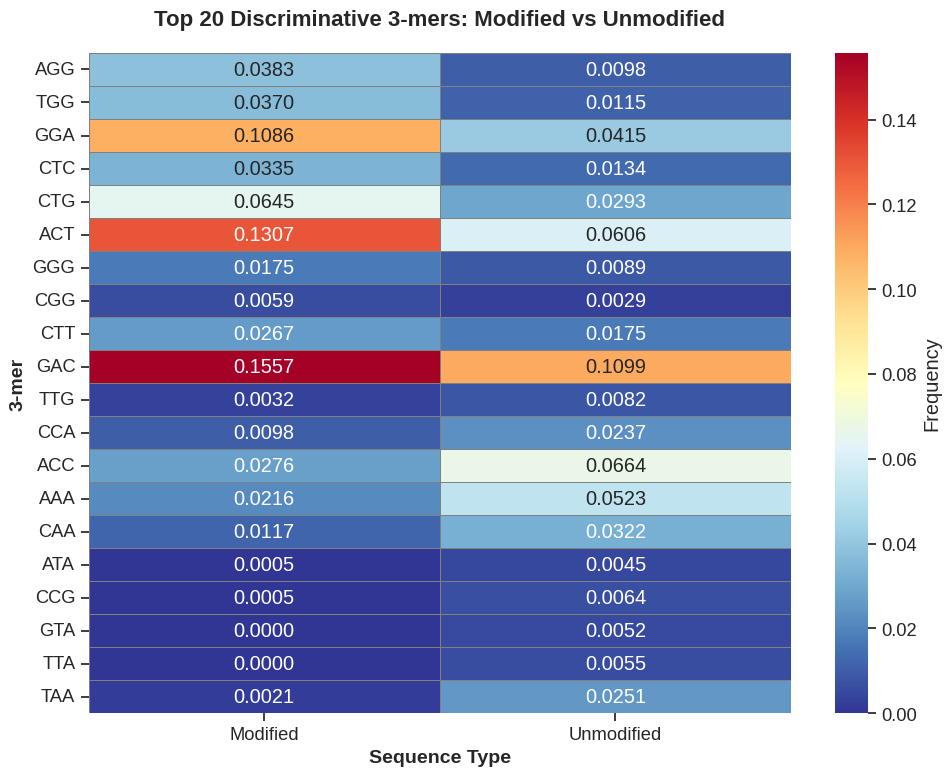

\n============================================================
3-MER FREQUENCY ANALYSIS
\nTop 5 Modified-Enriched 3-mers:
     Modified  Unmodified  Enrichment
AGG  0.038261    0.009839    1.856813
TGG  0.037008    0.011516    1.602481
GGA  0.108610    0.041527    1.365939
CTC  0.033470    0.013358    1.263518
CTG  0.064527    0.029275    1.113974
\nTop 5 Unmodified-Enriched 3-mers:
     Modified  Unmodified  Enrichment
ATA  0.000523    0.004475   -1.846401
CCG  0.000523    0.006368   -2.274640
GTA  0.000000    0.005209   -2.634270
TTA  0.000000    0.005491   -2.698481
TAA  0.002057    0.025087   -3.093080


,Modified,Unmodified,Enrichment
AGG,0.038261,0.009839,1.856813
TGG,0.037008,0.011516,1.602481
GGA,0.108610,0.041527,1.365939
CTC,0.033470,0.013358,1.263518
CTG,0.064527,0.029275,1.113974
ACT,0.130749,0.060567,1.097558
GGG,0.017475,0.008942,0.893925
CGG,0.005903,0.002899,0.824209
CTT,0.026749,0.017485,0.586054
GAC,0.155729,0.109897,0.499048


In [18]:
viz_kmer_heatmap(sequences_modified, sequences_unmodified, k=3)

### 3: Position-Specific Nucleotide Frequency

In [21]:
def viz_positional_frequencies(sequences_modified: List[str],
                              sequences_unmodified: List[str],
                              max_len: int = 7,
                              save_path: str = None):
    """
    Visualize position-specific nucleotide frequencies.

    Best Practice: Heatmaps for position weight matrices (Xia 2012)
    """
    # Get positional matrices
    pos_mod = get_positional_matrix(sequences_modified, max_len)
    pos_unmod = get_positional_matrix(sequences_unmodified, max_len)

    # Calculate difference
    pos_diff = pos_mod - pos_unmod

    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 14))

    # Plot 1: Modified sequences
    sns.heatmap(pos_mod.T, annot=True, fmt='.2f', cmap='YlOrRd',
                cbar_kws={'label': 'Frequency'}, ax=axes[0],
                linewidths=0.5, linecolor='gray')
    axes[0].set_title('Position-Specific Nucleotide Frequencies: Modified (m6A+)',
                      fontsize=14, fontweight='bold', pad=15)
    axes[0].set_xlabel('Position in 7-mer', fontsize=12)
    axes[0].set_ylabel('Nucleotide', fontsize=12)

    # Plot 2: Unmodified sequences
    sns.heatmap(pos_unmod.T, annot=True, fmt='.2f', cmap='YlGnBu',
                cbar_kws={'label': 'Frequency'}, ax=axes[1],
                linewidths=0.5, linecolor='gray')
    axes[1].set_title('Position-Specific Nucleotide Frequencies: Unmodified (m6A-)',
                      fontsize=14, fontweight='bold', pad=15)
    axes[1].set_xlabel('Position in 7-mer', fontsize=12)
    axes[1].set_ylabel('Nucleotide', fontsize=12)

    # Plot 3: Difference (Modified - Unmodified)
    sns.heatmap(pos_diff.T, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Frequency Difference'}, ax=axes[2],
                linewidths=0.5, linecolor='gray', vmin=-0.5, vmax=0.5)
    axes[2].set_title('Frequency Difference: Modified - Unmodified\\n(Red = Enriched in Modified, Blue = Enriched in Unmodified)',
                      fontsize=14, fontweight='bold', pad=15)
    axes[2].set_xlabel('Position in 7-mer', fontsize=12)
    axes[2].set_ylabel('Nucleotide', fontsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    # Print key insights
    print("\\n" + "="*60)
    print("POSITION-SPECIFIC ANALYSIS")
    print("="*60)
    print("\\nPositions with largest differences (|diff| > 0.3):")

    for pos in range(max_len):
        for nuc in ['A', 'T', 'G', 'C']:
            diff = pos_diff.loc[pos, nuc]
            if abs(diff) > 0.3:
                direction = "Modified" if diff > 0 else "Unmodified"
                print(f"  Position {pos}, Nucleotide {nuc}: {diff:+.3f} (Enriched in {direction})")


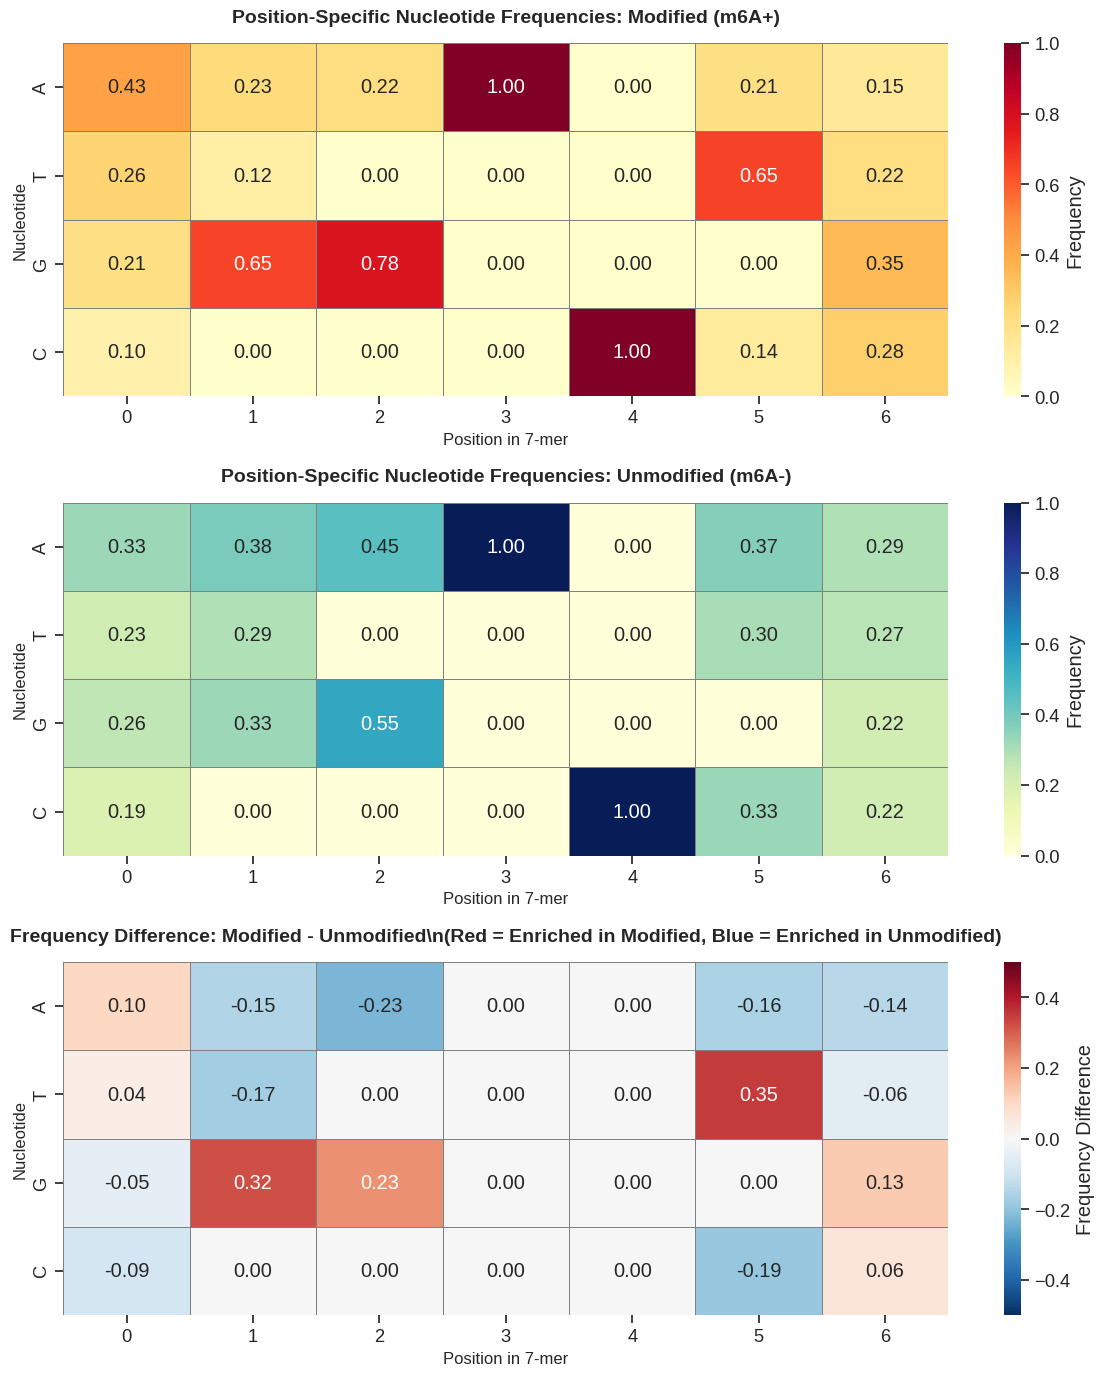

\n============================================================
POSITION-SPECIFIC ANALYSIS
\nPositions with largest differences (|diff| > 0.3):
  Position 1, Nucleotide G: +0.323 (Enriched in Modified)
  Position 5, Nucleotide T: +0.351 (Enriched in Modified)


In [22]:
viz_positional_frequencies(sequences_modified, sequences_unmodified)

### 4.Sequence Logo

In [23]:

def viz_sequence_logo(sequences: List[str],
                     title: str = "Sequence Logo",
                     save_path: str = None):
    """
    Create sequence logo visualization.

    Best Practice: Sequence logos for motif visualization (Wagih 2017, Tareen 2019)
    """
    if not LOGOMAKER_AVAILABLE:
        print("Logomaker not installed. Skipping sequence logo.")
        return

    # Create logo data
    logo_data = create_sequence_logo_data(sequences)

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 4))

    # Create logo
    logo = logomaker.Logo(logo_data, ax=ax, color_scheme='classic')

    # Style the logo
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)

    # Add labels
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_xlabel('Position', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)

    # Set x-axis ticks
    ax.set_xticks(range(len(logo_data)))
    ax.set_xticklabels(range(len(logo_data)))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


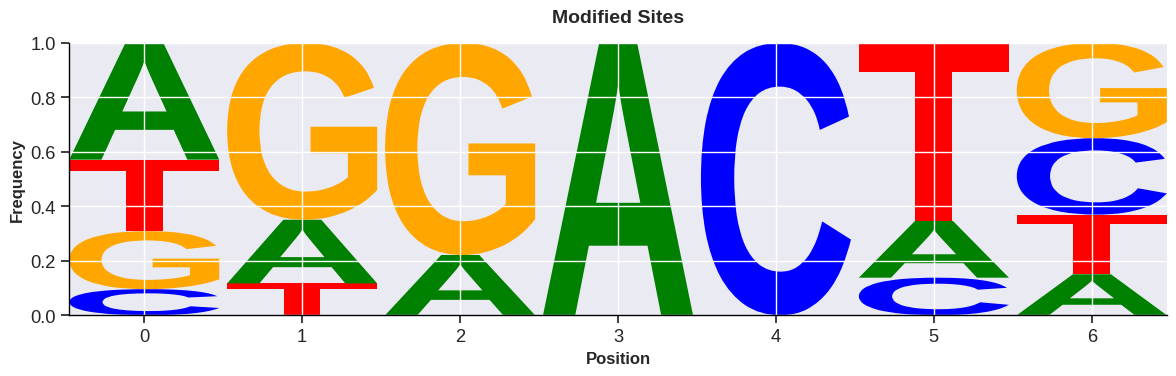

In [24]:
viz_sequence_logo(sequences_modified, "Modified Sites")

### 5.Feature Importance Comparison

In [27]:

def viz_feature_comparison(kmer_enrichment: pd.DataFrame,
                          save_path: str = None):
    """
    Visualize which features are most discriminative.

    Best Practice: Horizontal bar plots for feature importance
    """
    # Sort by absolute enrichment
    df_sorted = kmer_enrichment.copy()
    df_sorted['Abs_Enrichment'] = df_sorted['Enrichment'].abs()
    df_sorted = df_sorted.sort_values('Abs_Enrichment', ascending=True).tail(20)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Color bars based on direction of enrichment
    colors = ['#e74c3c' if x < 0 else '#3498db' for x in df_sorted['Enrichment']]

    y_pos = np.arange(len(df_sorted))
    ax.barh(y_pos, df_sorted['Enrichment'], color=colors, alpha=0.8, edgecolor='black')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_sorted.index)
    ax.set_xlabel('Log2 Fold Enrichment\\n(Negative = Unmodified, Positive = Modified)',
                 fontsize=12, fontweight='bold')
    ax.set_title('Top 20 Most Discriminative K-mers',
                fontsize=14, fontweight='bold', pad=15)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='x', alpha=0.3)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#3498db', alpha=0.8, label='Modified-enriched'),
        Patch(facecolor='#e74c3c', alpha=0.8, label='Unmodified-enriched')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


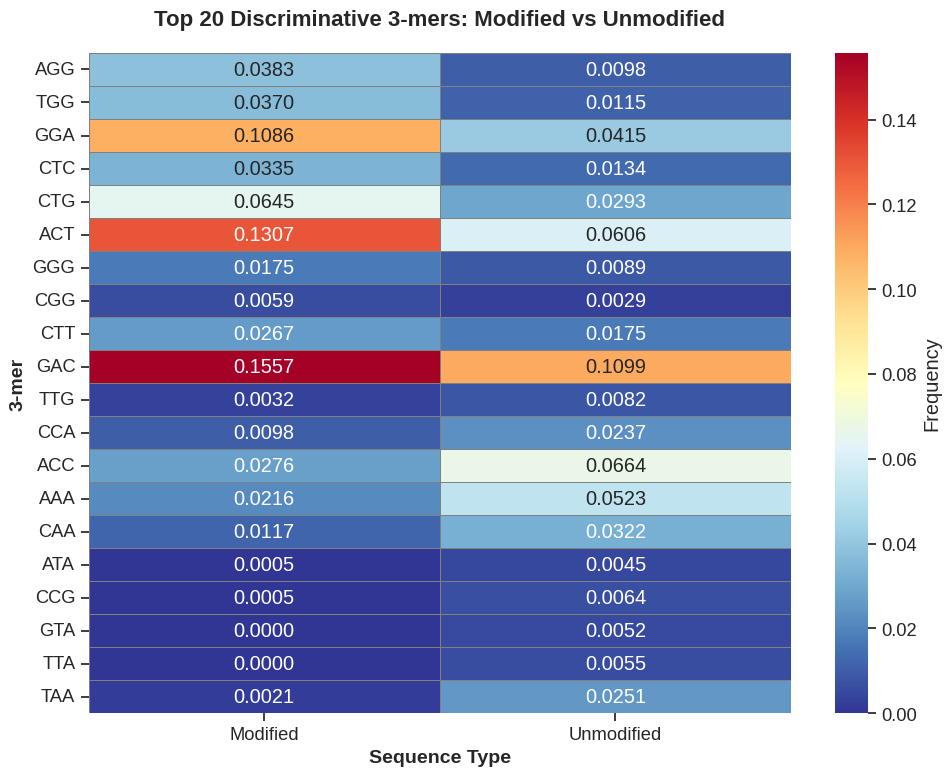

\n============================================================
3-MER FREQUENCY ANALYSIS
\nTop 5 Modified-Enriched 3-mers:
     Modified  Unmodified  Enrichment
AGG  0.038261    0.009839    1.856813
TGG  0.037008    0.011516    1.602481
GGA  0.108610    0.041527    1.365939
CTC  0.033470    0.013358    1.263518
CTG  0.064527    0.029275    1.113974
\nTop 5 Unmodified-Enriched 3-mers:
     Modified  Unmodified  Enrichment
ATA  0.000523    0.004475   -1.846401
CCG  0.000523    0.006368   -2.274640
GTA  0.000000    0.005209   -2.634270
TTA  0.000000    0.005491   -2.698481
TAA  0.002057    0.025087   -3.093080


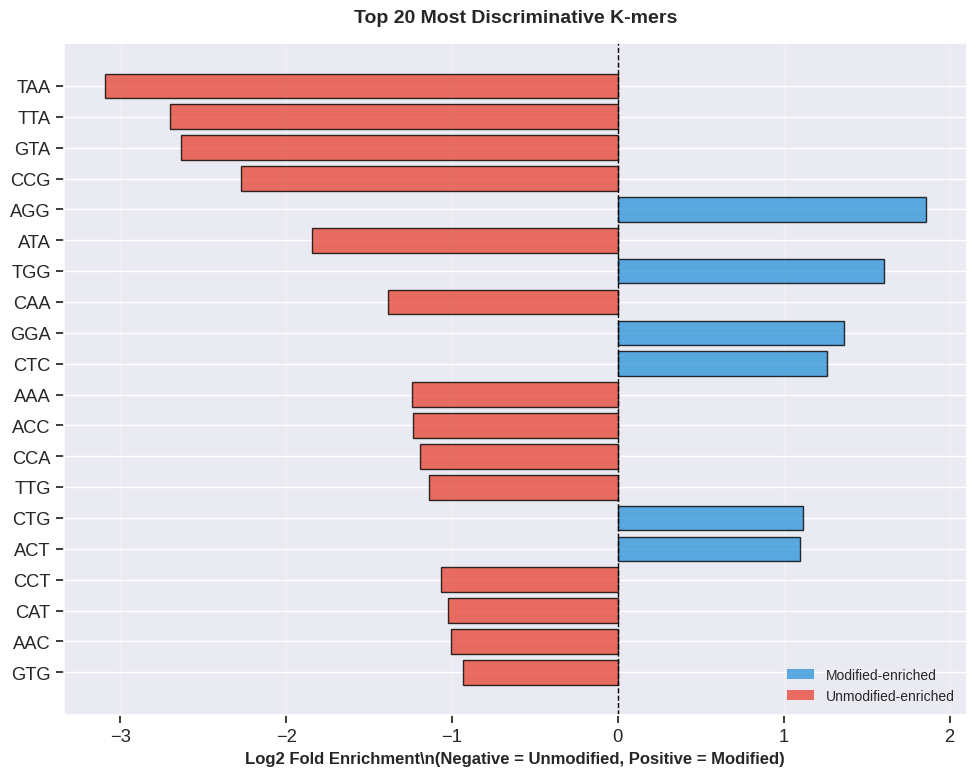

In [28]:
# Generate kmer_enrichment data
kmer_enrichment = viz_kmer_heatmap(sequences_modified, sequences_unmodified, k=3)

# Run feature comparison visualization
viz_feature_comparison(kmer_enrichment)

# Insights

Based on the visualizations above, here are recommended features to extract:

1. **K-MER FEATURES** (High Priority)
   - Extract 3-mers, 4-mers, and 5-mers
   - Focus on k-mers with high enrichment scores (|log2FC| > 1.5)
   - These capture local sequence patterns

2. **POSITIONAL FEATURES** (High Priority)
   - One-hot encoding of nucleotides at each position
   - Focus on positions with large frequency differences
   - These capture position-specific preferences

3. **COMPOSITION FEATURES** (Medium Priority)
   - GC content
   - Purine/Pyrimidine ratios
   - Individual nucleotide frequencies
   - These provide global sequence context

4. **SEQUENCE LOGO PATTERNS** (Low Priority, for interpretation)
   - Information content at each position
   - Consensus sequences
   - These help understand model predictions

1. Modified sites strongly prefer the GGACT DRACH variant:

Position 1: G enriched by +32.3%

Position 2: G strongly preferred (visible in logo)

Position 3: 100% A (DRACH center)

Position 4: 100% C (DRACH center)

Position 5: T enriched by +35.1%

Consensus pattern: X-G-G-A-C-T-X

This is one of the 18 canonical DRACH motifs and explains why:

Your modified sites show overall G-enrichment (+9.1%)

The T-enrichment at position 5 is the strongest positional signal in your data


2. Perfect Discriminator K-mers
Your k-mer analysis found exceptional discriminators:

Modified-enriched (use as positive features):

GGA (10.9% frequency, log2FC=1.37): Appears in 1 out of 10 modified sequences!

AGG (log2FC=1.86): 3.6× more frequent in modified

TGG (log2FC=1.60): 3.0× more frequent in modified

Unmodified-enriched (use as negative features):

TTA and GTA: Completely absent in modified sequences (perfect negative indicators)

TAA (log2FC=-3.09): 8.4× more frequent in unmodified

These are exceptionally strong features - several k-mers are completely absent in one group, making them perfect discriminators.